In [1430]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression

In [1431]:
np.random.seed(993)

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [1432]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [1433]:
def generate_data(m):
    # returns the true w as well as X, Y data
     # Step 1: Generate w* from a standard normal distribution
    w_true = np.random.randn(10)
    
    # Normalize w* to have an Euclidean norm of 1
    w_true /= np.linalg.norm(w_true)
    
    # Step 2: Generate the training set
    X = np.random.randn(m, 10)
    
    # Calculate the probability for y_i to be 1
    probabilities = sigmoid(np.dot(X, w_true))
    
    # Generate y_i based on the calculated probabilities
    Y = (np.random.rand(m) < probabilities)
    
    return w_true, X, Y.astype(int)

In [1434]:
# Generate a training set of size m=1000
m = 1000 
w_true, X, Y = generate_data(m)
w_true, X[:3], Y[:3] 

(array([-0.25341006, -0.19287204, -0.41216069, -0.04268381, -0.34641295,
        -0.67820632,  0.22466176,  0.07474183,  0.30060793, -0.02225414]),
 array([[-0.27370873, -0.42891938,  0.33997946, -1.38395275, -1.26803094,
          0.77075344, -0.13758242,  0.0097364 , -0.31732969, -1.13018121],
        [ 2.43087111,  1.02703708, -0.23978968,  0.38028561, -0.64605227,
         -1.60419942, -0.09352151, -0.55750271,  0.01557819, -0.44269975],
        [ 1.47063624, -1.07597569, -0.44150105, -0.59746506,  1.05251539,
         -0.57943281, -2.64988183,  0.0426168 ,  0.89858423, -0.67715191]]),
 array([1, 0, 0]))

In [1435]:
# Verify that w_true is normalized
np.linalg.norm(w_true)

0.9999999999999999

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [1436]:
def train_logistic_regression(X, Y):
    # Create a logistic regression model with a maximum of 1000 iterations
    model = LogisticRegression(max_iter=1000)
    # Fit the model to the training data
    model.fit(X, Y)
    # Return the learned coefficients
    return model.coef_

In [1437]:
# Test logistic regression model
learned_w_logistic = train_logistic_regression(X, Y)
learned_w_logistic

array([[-0.19939579, -0.22500125, -0.33915596, -0.1534194 , -0.37719182,
        -0.58590764,  0.25182984, -0.04095363,  0.30122248, -0.0672229 ]])

## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

In [1438]:
def gradient_descent(X, Y, eta=0.01, iterations=1000):
    m, n = X.shape
    w = np.zeros(n)
    gradient = np.zeros(n)
    for t in range(iterations):
        # gradient = np.zeros(n)
        for i in range(m):
            xi = X[i]
            yi = Y[i]
            prediction = sigmoid(np.dot(w, xi))
            gradient += (prediction - yi) * prediction * (1 - prediction) * xi
        gradient /= m
        w -= eta * gradient
    return w

In [1439]:
# Test the model with gradient descent
learned_w_gd = gradient_descent(X, Y)
learned_w_gd

array([-0.07358742, -0.08720365, -0.12091256, -0.05279556, -0.15002938,
       -0.21202142,  0.08956887, -0.01934616,  0.12497521, -0.02250047])

## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [1440]:
def stochastic_gradient_descent(X, Y, eta=0.01, iterations=1000):
    m, n = X.shape
    w = np.zeros(n)  # Initialize weights to zeros

    for t in range(iterations):
        # Sample a random index from the dataset
        i = np.random.randint(m)
        xi = X[i]
        yi = Y[i]
        prediction = sigmoid(np.dot(w, xi))
        gradient = (prediction - yi) * prediction * (1 - prediction) * xi
        w -= eta * gradient 

    return w

In [1441]:
# Test the model with stochastic gradient descent
learned_w_sgd = stochastic_gradient_descent(X, Y)
learned_w_sgd

array([-0.06799574, -0.14813307, -0.11986393, -0.03710569, -0.1639119 ,
       -0.20555064,  0.05995725, -0.03872701,  0.13862364,  0.03192013])

## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

In [1442]:
def eval_algorithm(algorithm, m_values, num_trials=10, eta=0.01, iterations=1000):
    wnd_list = []
    times = []
    
    for m in m_values:
        total_wnd = 0
        start_time = time.time()
        
        for _ in range(num_trials):
            # Generate fresh w* and fresh training data
            w_true, X, Y = generate_data(m)
            
            # Train the algorithm and get w_prime
            if algorithm == 'lr':
                w_prime = train_logistic_regression(X, Y).flatten()
            elif algorithm == 'gd':
                w_prime = gradient_descent(X, Y, eta, iterations)
            elif algorithm == 'sgd':
                w_prime = stochastic_gradient_descent(X, Y, eta, iterations)
            else:
                print("Algorithm incorrect")
                w_prime = None
            
            # Calculate the error
            wnd = np.linalg.norm(w_true - w_prime)
            total_wnd += wnd
        
        avg_wnd = total_wnd / num_trials
        wnd_list.append(avg_wnd)
        times.append(time.time() - start_time)
    
    return wnd_list, times

In [1443]:
# Set the sample sizes to evaluate
m_values = [50, 100, 150, 200, 250]

# Evaluate each algorithm
wnd_lr, times_lr = eval_algorithm('lr', m_values)
wnd_gd, times_gd = eval_algorithm('gd', m_values)
wnd_sgd, times_sgd = eval_algorithm('sgd', m_values)

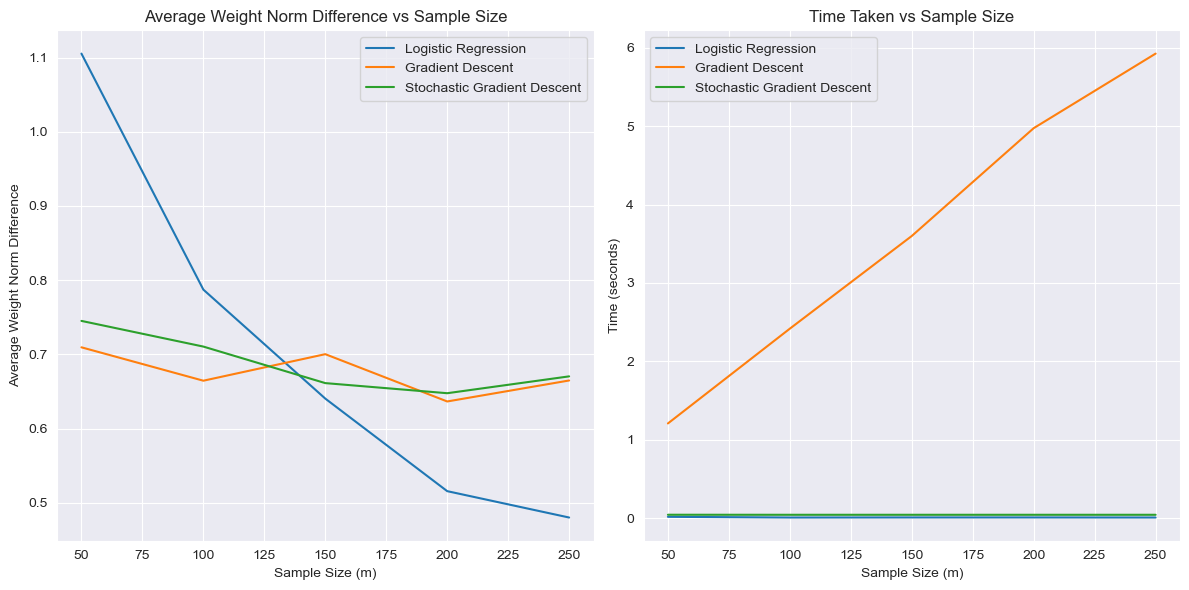

In [1444]:
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(m_values, wnd_lr, label='Logistic Regression')
plt.plot(m_values, wnd_gd, label='Gradient Descent')
plt.plot(m_values, wnd_sgd, label='Stochastic Gradient Descent')
plt.xlabel('Sample Size (m)')
plt.ylabel('Average Weight Norm Difference')
plt.title('Average Weight Norm Difference vs Sample Size')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(m_values, times_lr, label='Logistic Regression')
plt.plot(m_values, times_gd, label='Gradient Descent')
plt.plot(m_values, times_sgd, label='Stochastic Gradient Descent')
plt.xlabel('Sample Size (m)')
plt.ylabel('Time (seconds)')
plt.title('Time Taken vs Sample Size')
plt.legend()

plt.tight_layout()
plt.show()

In [1445]:
print("Logistic Regression Time: ", times_lr[4])
print("Gradient Descent Time: ", times_gd[4])
print("Stochastic Gradient Descent: ", times_sgd[4])

Logistic Regression Time:  0.008055925369262695
Gradient Descent Time:  5.925161600112915
Stochastic Gradient Descent:  0.04300117492675781


# Problem 2

In [1446]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [1447]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

C:\Users\Beckmans\anaconda3\envs\python_3-8\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Beckmans\anaconda3\envs\python_3-8\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Beckmans\anaconda3\envs\python_3-8\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Beckmans\anaconda3\envs\python_3-8\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\Beckmans\anaconda3\envs\python_3-8\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` 

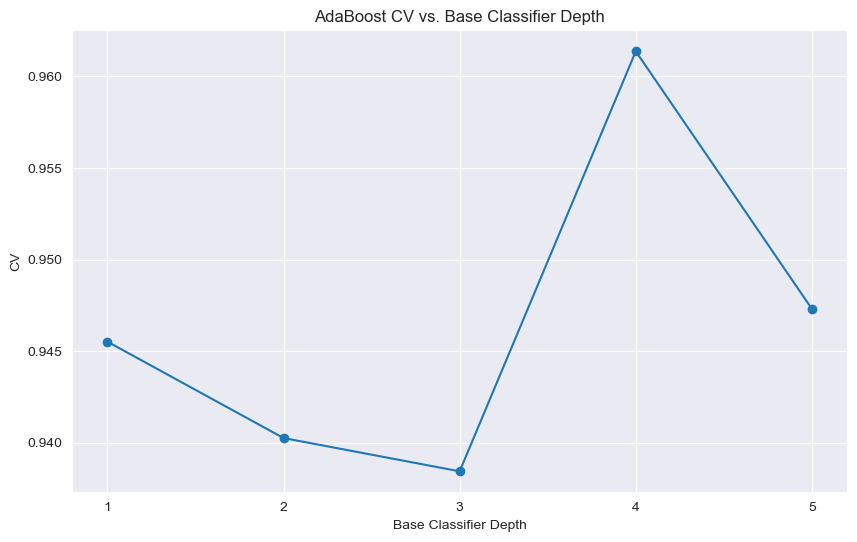

In [1448]:
# Load the breast cancer dataset
X, y = cancer.data, cancer.target

# Set the parameters
depths = range(1, 6)
n_estimators = 10
learning_rate = 1
random_state = 101

# Record the cross-validated errors
errors = []

for depth in depths:
    # Instantiate the base learner and AdaBoost classifier
    base_learner = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
    ada_boost = AdaBoostClassifier(base_estimator=base_learner, n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
    
    # Perform 10-fold cross-validation
    scores = cross_val_score(ada_boost, X, y, cv=10, scoring='accuracy')
    
    # Calculate the error as 1 - accuracy
    # error = 1 - scores.mean()
    error = scores.mean()
    errors.append(error)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, errors, marker='o')
plt.xlabel('Base Classifier Depth')
plt.ylabel('CV')
plt.title('AdaBoost CV vs. Base Classifier Depth')
plt.xticks(depths)
plt.grid(True)
plt.show()
